# **Pemodelan Topik | Universitas Internasional Semen Indonesia (UISI)**

In [13]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from gensim import corpora, models
import gensim
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import ast

# Baca dataset
df = pd.read_csv('../../../dataset/cleaned-data/UISI_Reviews_cleaned.csv')

# Konversi string representasi list menjadi list yang sebenarnya
df['tokenized_text'] = df['tokenized_text'].apply(ast.literal_eval)

In [14]:

# Buat Dictionary
dictionary = corpora.Dictionary(df['tokenized_text'])
print(dictionary)

Dictionary<358 unique tokens: ['35th', 'ac', 'ajar', 'bagus', 'dosen']...>


In [15]:


# Buat Corpus
corpus = [dictionary.doc2bow(text) for text in df['tokenized_text']]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)]]


In [16]:


# Fungsi untuk menghitung coherence score
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               num_topics=num_topics, 
                                               id2word=dictionary,
                                               random_state=42,
                                               passes=15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, 
                                      dictionary=dictionary, 
                                      coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Hitung coherence score untuk berbagai jumlah topik
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                      corpus=corpus,
                                                      texts=df['tokenized_text'],
                                                      start=2, limit=11, step=1)

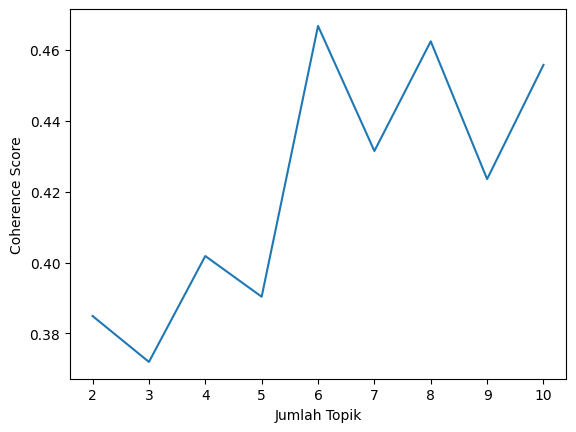

In [17]:
# Plot coherence scores
plt.plot(range(2, 11), coherence_values)
plt.xlabel("Jumlah Topik")
plt.ylabel("Coherence Score")
plt.show()

In [18]:
# Pilih model dengan coherence score terbaik
optimal_model = model_list[np.argmax(coherence_values)]

# Visualisasi dengan pyLDAvis
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'output_lda_visualization_UISI.html')

# Buat wordcloud untuk setiap topik
def plot_word_cloud(model, topic_number):
    topic_words = dict(model.show_topic(topic_number, 30))
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white').generate_from_frequencies(topic_words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topik {topic_number+1}')
    plt.show()

In [19]:
# Mendapatkan distribusi topik dari model optimal
topic_distribution = [sum([freq for _, freq in optimal_model.get_document_topics(doc)]) for doc in corpus]

In [20]:
# Hitung proporsi setiap topik
topic_counts = np.zeros(optimal_model.num_topics)

for doc in corpus:
    for topic_id, freq in optimal_model.get_document_topics(doc):
        topic_counts[topic_id] += freq

# Hitung persentase
topic_percentages = topic_counts / topic_counts.sum() * 100


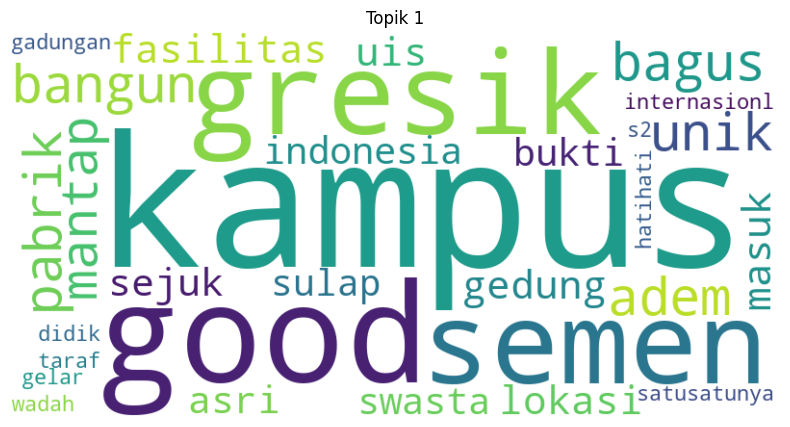

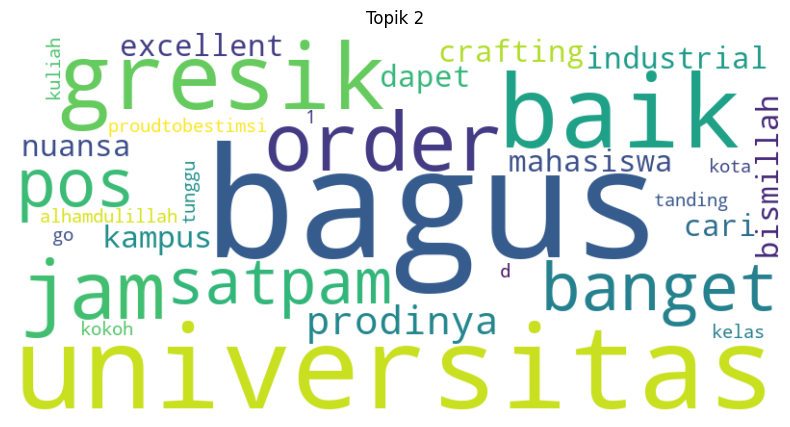

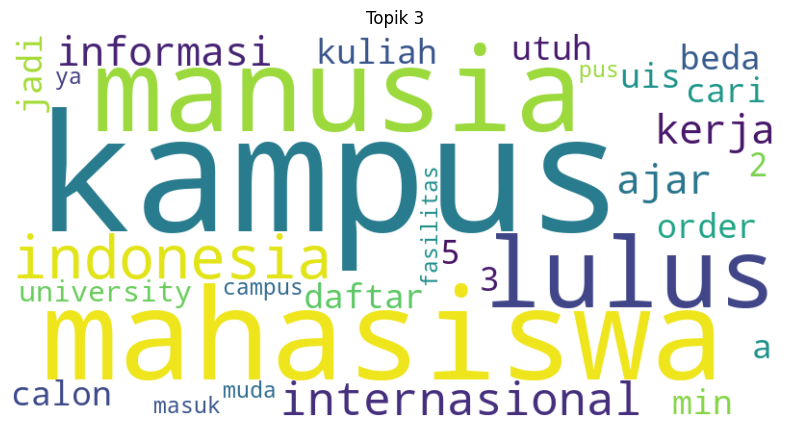

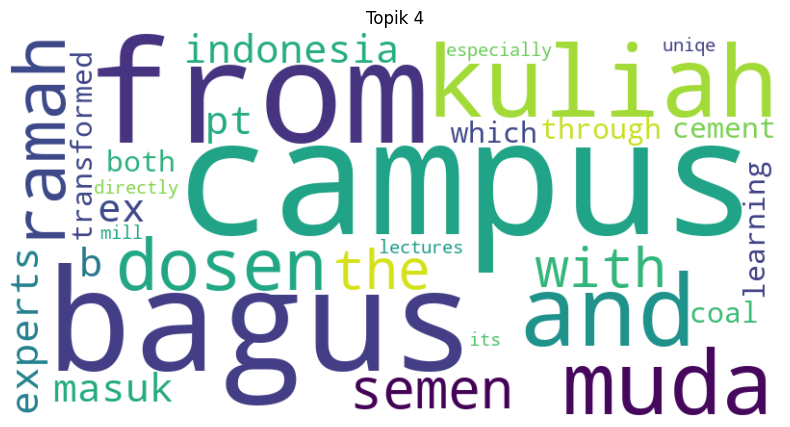

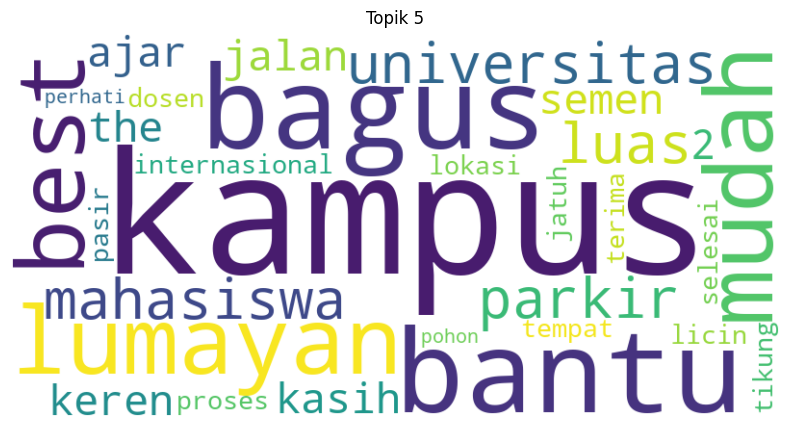

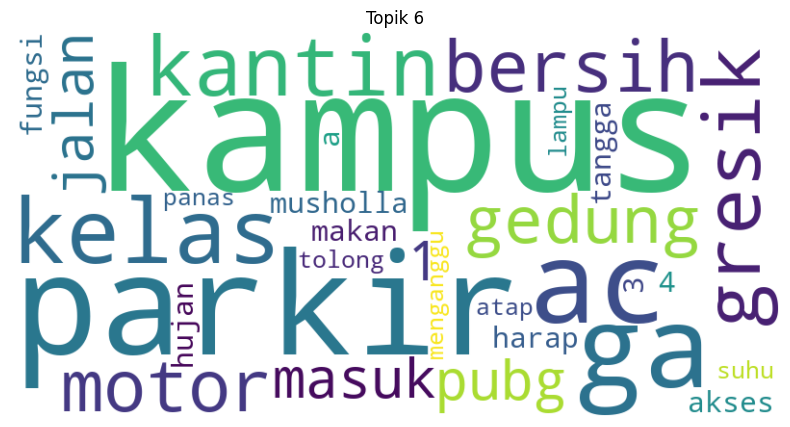

In [21]:
# Plot wordcloud untuk setiap topik
for i in range(optimal_model.num_topics):
    plot_word_cloud(optimal_model, i)

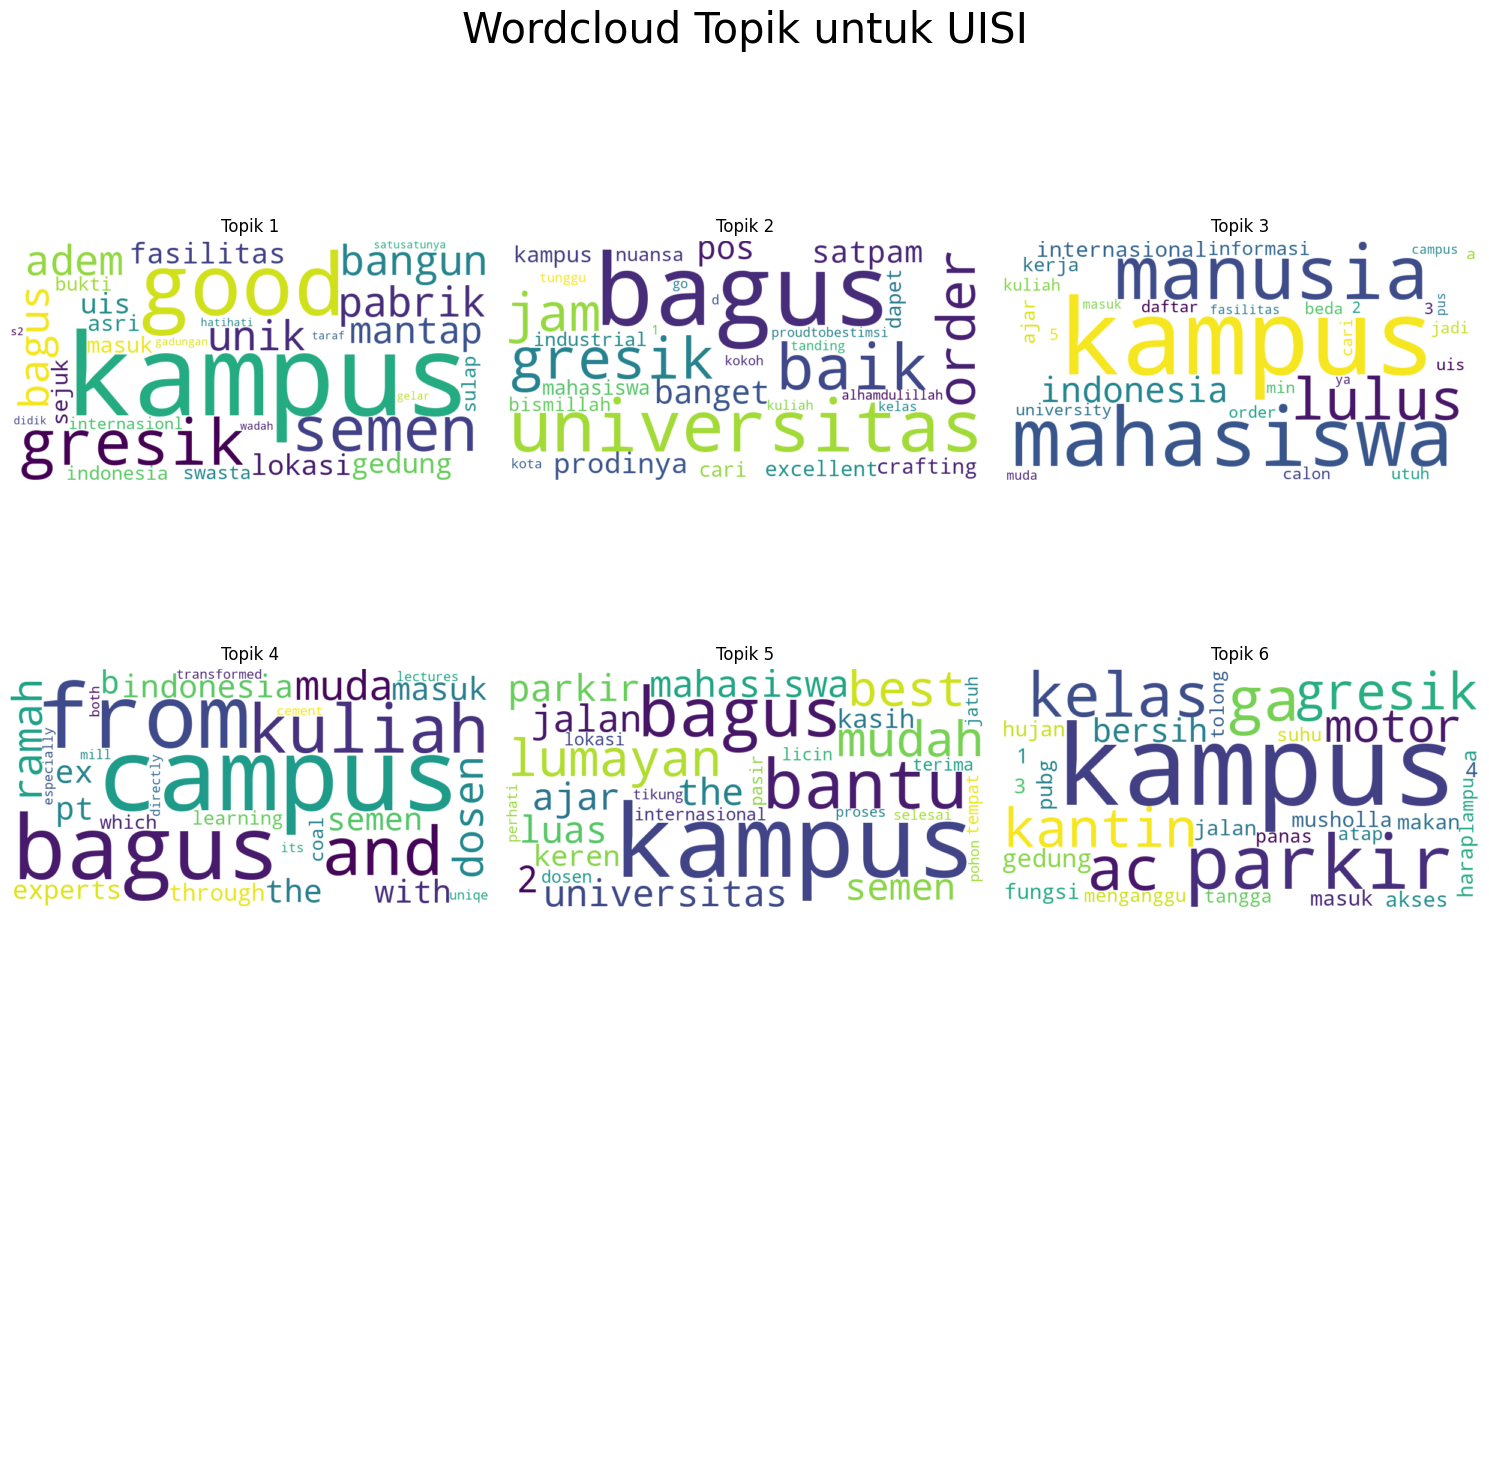

In [22]:
# Buat wordcloud untuk setiap topik dalam satu tampilan
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle('Wordcloud Topik untuk UISI', fontsize=30)

for i, ax in enumerate(axes.flatten()):
    if i < optimal_model.num_topics:
        topic_words = dict(optimal_model.show_topic(i, 30))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
        
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Topik {i+1}')
    else:
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [23]:
# Ambil topik dan kata-kata dominan dari model LDA
topic_keywords = []
for topic_id in range(optimal_model.num_topics):
    keywords = optimal_model.show_topic(topic_id, topn=5)  # Ambil 5 kata teratas
    keywords = [word for word, _ in keywords]
    topic_keywords.append(f"Topic {topic_id+1}: {', '.join(keywords)}")

# Data untuk pie chart
labels = topic_keywords
sizes = topic_percentages  # Proporsi topik
colors = plt.cm.tab10(np.arange(len(labels)))  # Pilih palet warna

# Ambil 5 topik teratas berdasarkan ukuran
top_indices = np.argsort(sizes)[-5:][::-1]  # Indeks 5 proporsi terbesar (descending)
labels_top5 = [labels[i] for i in top_indices]
sizes_top5 = [sizes[i] for i in top_indices]
colors_top5 = colors[top_indices]

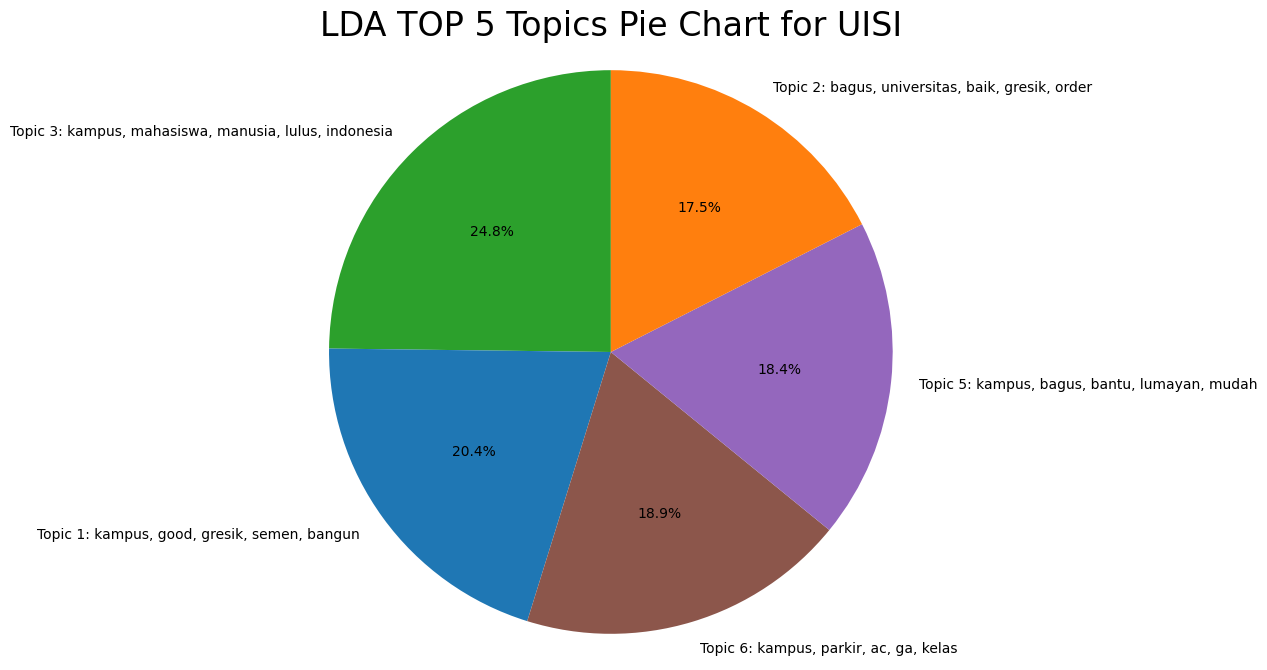

In [24]:
# Membuat pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes_top5, labels=labels_top5, autopct='%1.1f%%', startangle=90, colors=colors_top5)
plt.title('LDA TOP 5 Topics Pie Chart for UISI', fontsize=24)
plt.axis('equal')  # Membuat pie chart berbentuk lingkaran
plt.show()